In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


In [2]:
def maxmin1(x):
 
    max_value = x.max().item()
    print ('1:', max_value)
    min_value = x.min().item()  
    print ('2:', min_value)
    x_normalized = (x - min_value) / (max_value - min_value)
     
    return x_normalized

In [3]:
def partition(RG_GRFf_file_path, RG_GRFl_file_path, abn_ratio):

    with open(RG_GRFf_file_path, 'rb') as file:
        GRFf = pickle.load(file).astype(np.float32)[:,:1000,:]
    file.close()

    with open(RG_GRFl_file_path, 'rb') as file:
        GRFl = pickle.load(file).astype(np.float32)
    file.close()
    
    # stat indice for 0(abnormal)/1(healthy)
    GRFl_0_indice = np.where(GRFl==0)
    GRFl_1_indice = np.where(GRFl==1)
    
    # print ('6:', GRFl_0_indice)
    # print ('7:', GRFl_1_indice)
    
    # select the corresponding features for indice
    GRFl_features_0 = GRFf[list(GRFl_0_indice[0])]
    GRFl_features_1 = GRFf[list(GRFl_1_indice[0])]
    
    # select the corresponding features for indice
    GRFl_0 = GRFl[list(GRFl_0_indice[0])]
    GRFl_1 = GRFl[list(GRFl_1_indice[0])]

    # print (GRFl_features_0.shape)
    
    # print (GRFl_features_1.shape)
    
    # 67977 abnoraml / 16574 healthy, 因此至少
    # print (round(len(GRFl_0)/len(GRFl_1),3))
    
    # print (GRFl_0.shape)
    
    # print (GRFl_1.shape)

    # 训练样本
    #### Portation of  0(abnormal)
    total_sample_size = GRFl_features_0.shape[0]
    total_sample_range = list(np.arange(0, total_sample_size))
    train_sample_size = int(GRFl_features_0.shape[0] * abn_ratio)
    # 训练
    train_indices = np.random.choice(GRFl_features_0.shape[0], size = train_sample_size, replace=False)
    # print ('1:', indices)
    # print ('2:', type(indices))
    # print ('3:', indices.shape)
    GRFl_features_0_portion_train = GRFl_features_0[train_indices]
    GRFl_0_portion_train = GRFl_0[train_indices]
    # print ('4:', GRFl_features_0_portion)
    # print ('5:', type(GRFl_features_0_portion))
    # print ('6:', GRFl_features_0_portion.shape)
    # print ('44:', GRFl_0_portion)
    # print ('7:', type(GRFl_0_portion))
    # print ('8:', GRFl_0_portion.shape)    
    #### Concatenate of  0(abnormal) + 1(healthy)
    ## 3398 + 16574 = 19972
    GRFf_train = np.concatenate((GRFl_features_0_portion_train, GRFl_features_1),axis = 0)
    GRFl_train = np.concatenate((GRFl_0_portion_train, GRFl_1),axis = 0)
    # print ('9:', type(GRFf)) 
    # print ('10:', GRFf.shape) 
    # print ('11:', type(GRFl)) 
    # print ('12:', GRFl.shape)
    
    # 测试样本
    test_indices = []
    for e in total_sample_range:
        if e not in train_indices:
            # test_indices.append(np.where(total_sample_range==e)[0][0])
            test_indices.append(e)
            
    ##
    test_indices = np.array(test_indices)
    GRFl_features_0_portion_test = GRFl_features_0[test_indices]
    GRFl_0_portion_test = GRFl_0[test_indices]
    ##
    GRFf_test = np.concatenate((GRFl_features_0_portion_test, GRFl_features_1), axis = 0)
    GRFl_test = np.concatenate((GRFl_0_portion_test, GRFl_1), axis = 0)

    ####
    print ('13:', GRFf_train.shape)
    print ('14:', GRFl_train.shape)
    print ('15:', GRFf_test.shape)
    print ('16:', GRFl_test.shape)

    return GRFf_train, GRFl_train, GRFf_test, GRFl_test

In [4]:
def balance_01(X, Y):
    GRFf = X
    GRFl = Y
    # 使用SMOTE进行过采样时正样本和负样本要放在一起，生成比例1：1
    smo = SMOTE(n_jobs=-1)
    # 这里必须是fit_resample()，有些版本是fit_sample()无法运行
    #### reshape, 用KNN来插值维度必须是1D
    GRFf_1d = GRFf.reshape(GRFf.shape[0], -1)
    # print ('test1:', GRFf.shape)
    # 特征维度
    GRFf_1d_fnum = GRFf.shape[1]
    
    # print ('1:', GRFf_1d.shape)
    GRFf_re, GRFl_re = smo.fit_resample(GRFf_1d, GRFl)
    
    # print ('2:', GRFf_re.shape)
    # print ('3:', GRFl_re.shape)
    # 样本
    GRFf_re = GRFf_re.reshape(GRFf_re.shape[0], GRFf_1d_fnum, -1)
    #
    # print ('4:', GRFf_re.shape)
    
    
    #### test the distribution proportion
    #
    #
    GRFl_re_0_indice = np.where(GRFl_re==0)
    GRFl_re_1_indice = np.where(GRFl_re==1)
    
    #### 1:1，少数类样本0(疾病人群)数量增加为16574(0.05)
    # print ('5:', len(list(GRFl_re_0_indice[0]))) 
    # print ('6:', len(list(GRFl_re_1_indice[0]))) 
    # print ('7:', GRFf_re)
    #
    #
    #
    print ('17:', len(list(GRFl_re_0_indice[0])))
    print ('18:', len(list(GRFl_re_1_indice[0])))    
    
    return GRFf_re, GRFl_re

In [5]:
# ---------------1、load---------------
RG_GRFf_file_path = 'nihgrff.pkl'
RG_GRFl_file_path = 'nihgrfl.pkl'


# part ratio，这里健康样本是陪衬，一直要加上
# abn_ratio = 0.3 # 30%训练
# abn_ratio = 0.2 # 20%训练
abn_ratio = 0.1 # 10%
# abn_ratio = 0.05 # 5%


# 按比例切分样本，但目前是固定10%:90%, 20%:80%, 30%:70%, 但目前的10% 20% 30%必须变起来写成随机化的(sampler???)
GRFf_train_part, GRFl_train_part, GRFf_val_part, GRFl_val_part  =  partition(RG_GRFf_file_path, RG_GRFl_file_path, abn_ratio)
# 平衡训练集样本量，正负样本数为1:1
GRFf_train_ba, GRFl_train_ba = balance_01(GRFf_train_part, GRFl_train_part)
# 平衡训练集样本量，正负样本数为1:1
GRFf_val_ba, GRFl_val_ba = balance_01(GRFf_val_part, GRFl_val_part)

# ------------------------ 2、normlization max-min scaler------------------------
GRFf_train = torch.from_numpy(GRFf_train_ba)
GRFf_train = maxmin1(GRFf_train)

GRFf_val = torch.from_numpy(GRFf_val_ba)
GRFf_val = maxmin1(GRFf_val)

#
GRFl_train = torch.from_numpy(GRFl_train_ba)
GRFl_val = torch.from_numpy(GRFl_val_ba)

# ------------------------ 3、Tensor Dataset------------------------
train_set = TensorDataset(GRFf_train, GRFl_train)
val_set = TensorDataset(GRFf_val, GRFl_val)




13: (75, 1000, 19)
14: (75,)
15: (163, 1000, 19)
16: (163,)
17: 64
18: 64
17: 99
18: 99
1: 1589.93994140625
2: 0.0
1: 1589.93994140625
2: 0.0


In [6]:
# -----------------4、dataloader------------------------

abn_ratio = 0.01 # 1% 
val_percent = 0.3
train_batch_size = 32
test_batch_size = 64
workers  = 3
pin_memory = True

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = train_batch_size,
    shuffle = True,
    num_workers = workers,
    pin_memory = pin_memory,
    sampler = None
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size = test_batch_size,
    shuffle = False,
    num_workers = workers,
    pin_memory = pin_memory
)

print ('11:', train_loader)
print ('12:', val_loader)

print ('13:', len(train_loader))
print ('14:', len(val_loader))

11: <torch.utils.data.dataloader.DataLoader object at 0x000001A8DA5117D0>
12: <torch.utils.data.dataloader.DataLoader object at 0x000001A8DA52E9D0>
13: 4
14: 4


In [ ]:
#### DataSet 

In [ ]:
### Inception_ResNet Model

In [7]:
# 卷积组: Conv1d+BN+ReLU
class BasicConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(BasicConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Stem: BasicConv1d + MaxPool
class Stem(nn.Module):
    def __init__(self, in_channels):
        super(Stem, self).__init__()

        # conv3x3(32 stride2 valid)
        self.conv1 = BasicConv1d(in_channels, 32, 3, padding=1)
        # conv3*3(32 valid)
        self.conv2 = BasicConv1d(32, 32, kernel_size=3,padding=1)
        # conv3*3(64)
        self.conv3 = BasicConv1d(32, 64, kernel_size=3, padding=1)

        # maxpool3*3(stride2 valid)
        self.maxpool4 = nn.MaxPool1d(kernel_size=3, padding=1)

        # conv1*1(80)
        self.conv5 = BasicConv1d(64, 80, kernel_size=1)
        # conv3*3(192 valid)
        self.conv6 = BasicConv1d(80, 192, kernel_size=1)

        # conv3*3(256 stride2 valid)
        self.conv7 = BasicConv1d(192, 256, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.maxpool4(self.conv3(self.conv2(self.conv1(x))))
        x = self.conv7(self.conv6(self.conv5(x)))
        return x

# Inception_ResNet_A:BasicConv1d+MaxPool1d × 5
class Inception_ResNet_A(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch3x3redX2, ch3x3X2_1, ch3x3X2_2, ch1x1ext, scale=1.0):
        super(Inception_ResNet_A, self).__init__()
        # 缩减指数
        self.scale = scale
        # conv1*1(32) 32 × 32 × 101
        self.branch_0 = BasicConv1d(in_channels, ch1x1, 1)
        # conv1*1(32)+conv3*3(32)
        # 32 × 32 × 101 → 32 × 32 × 101
        self.branch_1 = nn.Sequential(
            BasicConv1d(in_channels, ch3x3red, 1),
            BasicConv1d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )
        # conv1*1(32)+conv3*3(32)+conv3*3(32)
        #
        #
        #
        self.branch_2 = nn.Sequential(
            BasicConv1d(in_channels, ch3x3redX2, 1),
            BasicConv1d(ch3x3redX2, ch3x3X2_1, kernel_size=3, padding=1),
            BasicConv1d(ch3x3X2_1, ch3x3X2_2, kernel_size=3, padding=1)
        )
        # conv1*1(256)
        self.conv = BasicConv1d(ch1x1+ch3x3+ch3x3X2_2, ch1x1ext, 1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        # 通道维度拼接 96
        x_res = torch.cat((x0, x1, x2), dim=1)
        # 残差连接 256
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)


# Inception_ResNet_B:BasicCon1d+MaxPool1d
class Inception_ResNet_B(nn.Module):
    def __init__(self, in_channels, ch1x1, ch_red, ch_1, ch_2, ch1x1ext, scale=1.0):
        super(Inception_ResNet_B, self).__init__()
        # 缩减指数
        self.scale = scale
        # conv1*1(128) 
        self.branch_0 = BasicConv1d(in_channels, ch1x1, 1)
        # conv1*1(128)+conv1*7(128)+conv1*7(128)
        self.branch_1 = nn.Sequential(
            BasicConv1d(in_channels, ch_red, 1),
            BasicConv1d(ch_red, ch_1, 1),
            BasicConv1d(ch_1, ch_2, 1)
        )
        # conv1*1(896)
        self.conv = BasicConv1d(ch1x1+ch_2, ch1x1ext, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        # 拼接 256 → 896
        x_res = torch.cat((x0, x1), dim=1)
        # 残差操作
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)

# Inception_ResNet_C:BasicConv1d+MaxPool1d
class Inception_ResNet_C(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3redX2, ch3x3X2_1, ch3x3X2_2, ch1x1ext,  scale=1.0, activation=True):
        super(Inception_ResNet_C, self).__init__()
        # 缩减指数
        self.scale = scale
        # 是否激活
        self.activation = activation
        # conv1*1(192)
        self.branch_0 = BasicConv1d(in_channels, ch1x1, 1)
        # conv1*1(192)+conv1*3(192)+conv3*1(192)
        self.branch_1 = nn.Sequential(
            BasicConv1d(in_channels, ch3x3redX2, 1),
            BasicConv1d(ch3x3redX2, ch3x3X2_1, kernel_size=3, padding=1),
            BasicConv1d(ch3x3X2_1, ch3x3X2_2, kernel_size=3, padding=1)
        )
        # conv1*1(1792)
        self.conv = BasicConv1d(ch1x1+ch3x3X2_2, ch1x1ext, 1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        # 拼接
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        # 残差 通道连接输出为1792
        if self.activation:
            return self.relu(x + self.scale * x_res)
        return x + self.scale * x_res

# redutionA:BasicConv1d+MaxPool1d
class redutionA(nn.Module):
    def __init__(self, in_channels, k, l, m, n):
        super(redutionA, self).__init__()
        # conv3*3(n stride2 valid) 384
        self.branch1 = nn.Sequential(
            BasicConv1d(in_channels, n, kernel_size=3, padding=1),
        )
        # conv1*1(k)+conv3*3(l)+conv3*3(m stride2 valid) 256
        self.branch2 = nn.Sequential(
            BasicConv1d(in_channels, k, kernel_size=1),
            BasicConv1d(k, l, kernel_size=3, padding=1),
            BasicConv1d(l, m, kernel_size=3, padding=1)
        )
        # maxpool3*3(stride2 valid) 256
        self.branch3 = nn.Sequential(nn.MaxPool1d(kernel_size=3, padding=1, stride=1))

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        # 拼接 通道维度为(384 + 256*2 = 896)
        # print ('1:', branch1.shape)
        # print ('2:', branch2.shape)
        # print ('3:', branch3.shape)
        outputs = [branch1, branch2, branch3]
        return torch.cat(outputs, 1)

# redutionB:BasicConv1d+MaxPool1d
class redutionB(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_1, ch3x3_2, ch3x3_3, ch3x3_4):
        super(redutionB, self).__init__()
        # conv1*1(256)+conv3x3(384 stride2 valid)
        self.branch_0 = nn.Sequential(
            BasicConv1d(in_channels, ch1x1, 1),
            BasicConv1d(ch1x1, ch3x3_1, kernel_size=3, padding=1)
        )
        # conv1*1(256)+conv3x3(256 stride2 valid)
        self.branch_1 = nn.Sequential(
            BasicConv1d(in_channels, ch1x1, 1),
            BasicConv1d(ch1x1, ch3x3_2, kernel_size=3, padding=1),
        )
        # conv1*1(256)+conv3x3(256)+conv3x3(256 stride2 valid)
        self.branch_2 = nn.Sequential(
            BasicConv1d(in_channels, ch1x1, 1),
            BasicConv1d(ch1x1, ch3x3_3, kernel_size=3, padding=1),
            BasicConv1d(ch3x3_3, ch3x3_4, kernel_size=3, padding=1)
        )
        # maxpool3*3(stride2 valid)
        self.branch_3 = nn.MaxPool1d(kernel_size=3, padding=1, stride=1)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        # 四个拼接 384 + 256 +256 +256 = 1152
        return torch.cat((x0, x1, x2, x3), dim=1)

class Inception_ResNetv1(nn.Module):
    def __init__(self, num_classes = 1, k=192, l=192, m=256, n=384):
        super(Inception_ResNetv1, self).__init__()
        blocks = []
        # 1、19作为输入，256输出
        blocks.append(Stem(19))
        # 2、
        for i in range(5):
            blocks.append(Inception_ResNet_A(256,32, 32, 32, 32, 32, 32, 256, 0.17))
        blocks.append(redutionA(256, k, l, m, n))
        # 3、
        for i in range(10):
            blocks.append(Inception_ResNet_B(896, 128, 128, 128, 128, 896, 0.10))
        blocks.append(redutionB(896,256, 384, 256, 256, 256))
        # 4、
        for i in range(4):
            blocks.append(Inception_ResNet_C(1792,192, 192, 192, 192, 1792, 0.20))
        blocks.append(Inception_ResNet_C(1792, 192, 192, 192, 192, 1792, activation=False))
        
        self.features = nn.Sequential(*blocks)
        self.conv = BasicConv1d(1792, 1536, 1)
        #
        self.global_average_pooling = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.8)
        #
        self.linear = nn.Linear(1536, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(torch.transpose(x,1,2))
        x = self.conv(x)
        x = self.global_average_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x) # B * F
        X = self.sigmoid(x).squeeze() # B
        # print ('X:', X)
        # print ('X_shape:', X.shape)
        
        return X

# if __name__ == '__main__':
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model = Inception_ResNetv1().to(device)
#     summary(model, input_size=(3, 229, 229))


In [ ]:
### DataSet API

In [ ]:
### Setting

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Inception_ResNetv1().to(device)
print (net)
net=net.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
# 0.1 reduce / 10 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

###
# epochs = 100

epochs = 1


# acc
def accuracy_fn(y_true, y_pred):
    y_pred = y_pred>0.5
    y_pred = torch.where(y_pred, 1, 0)
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100
    return acc


# confusion matrix
# 混淆矩阵计算
def calculate_performance_metrics(y_true, y_pred, labels):

    # 预测矩阵转换0 1矩阵
    y_pred = y_pred>0.5
    y_pred = torch.where(y_pred,1,0)

    # print ('0:', y_pred)
    # print ('00:', y_true)
    # print ('0_:', y_pred.shape)
    # print ('00_:', y_true.shape)
    

    # 再转换为numpy类型
    # y_pred = y_pred.detach().numpy()
    y_pred = y_pred.cpu().numpy()
    
    # y_true = y_true.detach().numpy()
    y_true = y_true.cpu().numpy()

    # print ('11:', type(y_pred))
    # print ('22:', type(y_true))
    # print ('33:', y_pred.shape)
    # print ('44:', y_true.shape)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    # 混淆矩阵画图
#     fx = plot_cm(cm)
    
    # 计算精度
    precision = precision_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算召回率
    recall = recall_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算F1分数
    f1 = f1_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算平衡F1分数
    # 这里假设有一个函数balanced_accuracy_score来计算平衡F1分数
    balanced_f1 = balanced_accuracy_score(y_true, y_pred)
    
    return cm, precision, recall, f1, balanced_f1

Inception_ResNetv1(
  (features): Sequential(
    (0): Stem(
      (conv1): BasicConv1d(
        (conv): Conv1d(19, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (conv2): BasicConv1d(
        (conv): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (conv3): BasicConv1d(
        (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (maxpool4): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
      (conv5): BasicConv1d(
        (conv): Conv1d(64, 80, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(80, eps

In [ ]:
### Timing

In [13]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device:torch.device =None):
    total_time = end - start
    print(f"Train time on {device}:{total_time:.3f} seconds")
    return total_time
 
start_time = timer()
# 模型的运算在此处进行……
end_time = timer()
print_train_time(start=start_time,end=end_time,device="cpu")
 
# 运行结果
# Train time on cpu:0.000 seconds
# 3.819999983534217e-05

Train time on cpu:0.000 seconds


2.2900057956576347e-05

In [ ]:
### Training

In [14]:
from tqdm import *
torch.manual_seed(42)
train_time_start_on_cpu = timer() 
 
##############################################
for epoch in tqdm(range(epochs)):  
    print(f"Epoch:{epoch}\n------")
    train_loss = 0 
    for batch,(X,y) in enumerate(train_loader): 
        #
        X, y = X.to(device), y.to(device)

        # print ('55:', X.shape)
        # print ('66:', y.shape)
        net.train() 
        y_pred = net(X)
        #
        # print ('1:', y_pred)
        # print ('2:', y_pred.shape)
        # print ('3:', y)
        # print ('4:', y.shape)        
 
        loss = criterion(y_pred, y)
        # print ('train_loss:', loss)
        train_loss+=loss
        
        optimizer.zero_grad()
 
        loss.backward()
        # 
        optimizer.step()
        scheduler.step()
 
        # if batch % 400 == 0:
        if batch % 400 == 0:
            print(f"Look at {batch * len(X)}/{len(train_loader.dataset)} samples.")
            # break
 
    train_loss /= len(train_loader)
    

    ###################val/per epoch###########################
    val_loss, val_acc = 0, 0 
    precision_t = 0
    recall_t = 0
    f1_t = 0
    balanced_f1_t = 0
    cm_t = np.zeros((2,2))
    net.eval() 

    with torch.inference_mode():
        for x_val, y_val in val_loader:
            #
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = net(x_val) 
            val_loss+=criterion(val_pred, y_val)
            # print ('test_loss:', loss)
            # print ('val_pred:', val_pred)
            # print ('y_val:', y_val)
            # print ('val_pred:', val_pred.shape)
            # print ('y_val:', val_pred.shape)
            val_acc += accuracy_fn(y_true = y_val, y_pred = val_pred)
            cm, precision, recall, f1, balanced_f1 = calculate_performance_metrics(y_true = y_val, y_pred = val_pred, labels=[0,1])
            
            precision_t += precision
            recall_t += recall
            f1_t += f1
            balanced_f1_t += balanced_f1
            cm_t += cm
            
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        precision_t /=len(val_loader)
        recall_t /=len(val_loader)
        f1_t /=len(val_loader)
        balanced_f1_t /=len(val_loader)
        
        
    
    print(f"\nTrain loss:{train_loss:.4f} | Test loss:{val_loss:.4f}, Test acc:{val_acc:.4f}")
    
    print ('avg-precision:', precision_t)
    print ('avg-recall:', recall_t)
    print ('avg-f1:', f1_t)
    print ('avg-balanced_f1:', balanced_f1_t)
    print ('last-cm:', cm_t)


# 计算训练时间
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(net.parameters()).device))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Epoch:0
------
Look at 0/128 samples.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Train loss:0.5747 | Test loss:0.8417, Test acc:38.6719
avg-precision: 0.193359375
avg-recall: 0.25
avg-f1: 0.2133838383838384
avg-balanced_f1: 0.375
last-cm: [[ 99.  64.]
 [163.  64.]]
Train time on cuda:0:5.113 seconds


cm_total: [[ 99.  64.]
 [163.  64.]]
1: [99. 64.]
2: 163.0
conf_matrix: [array([0.60736196, 0.39263804]), array([0.71806167, 0.28193833])]


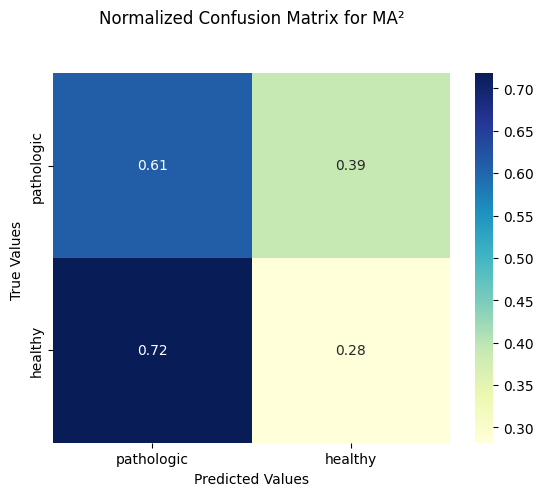

<function matplotlib.pyplot.cla() -> 'None'>

In [13]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random

# conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(7)))
# conf_matrix = [conf_matrix[i]*1.0/sum(conf_matrix[i]) for i in range(len(conf_matrix))]

# Using Seaborn heatmap to create the plot
# fx = sebrn.heatmap(conf_matrix, annot=True, cmap="turbo")

# # labels the title and x, y axis of plot
# fx.set_title("Plotting Confusion Matrix using Seaborn\n\n")
# fx.set_xlabel("Predicted Values")
# fx.set_ylabel("Actual Values ")

# # labels the boxes
# fx.xaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])
# fx.yaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])

# atlas.show()

#### 混淆矩阵画图
print ('cm_total:', cm_t)

print ('1:', cm_t[0])
print ('2:', sum(cm_t[0]))

conf_matrix = [cm_t[i]*1.0/sum(cm_t[i]) for i in range(len(cm_t))]

# conf_matrix = cm_total

print ('conf_matrix:', conf_matrix)
fx = sebrn.heatmap(conf_matrix, annot=True, cmap="YlGnBu")
# fx = sebrn.heatmap(cm_t, annot=True, cmap="YlGnBu")

# sn.heatmap(cm_total,annot=True)

fx.set_title("Normalized Confusion Matrix for MA²\n\n")
# fx.set_title("Confusion Matrix for MA²\n\n")
#
fx.set_xlabel("Predicted Values")
fx.set_ylabel("True Values ")

fx.xaxis.set_ticklabels(['pathologic', 'healthy',])
fx.yaxis.set_ticklabels(['pathologic', 'healthy',])
plt.savefig("MA2_con", dpi=330)
plt.show()

plt.cla
